# Determine Cell Cycles

In [ ]:
suppressPackageStartupMessages(library(SingleCellExperiment))
suppressPackageStartupMessages(library(scater))
suppressPackageStartupMessages(library(scran))
suppressPackageStartupMessages(library(argparse))
suppressPackageStartupMessages(library(edgeR))
suppressPackageStartupMessages(library(ggrastr))
suppressPackageStartupMessages(library(Seurat))
suppressPackageStartupMessages(library(scran))

#####################
## Define settings ##
#####################
here::i_am("processing/1_create_seurat_rna.R")
source(here::here("settings.R"))
source(here::here("utils.R"))
source(here::here("mapping/run/mnn/mapping_functions.R"))

args = list()
args$sce <- io$rna.sce
args$metadata <- paste0(io$basedir,"/results/rna/mapping/sample_metadata_after_mapping.txt.gz")
args$outdir = paste0(io$basedir,"/results/rna/cell_cycle/")

dir.create(args$outdir, recursive=TRUE, showWarnings = FALSE)

In [10]:
##########################
## Load sample metadata ##
##########################

sample_metadata <- fread(args$metadata) %>%
   .[pass_rnaQC==TRUE & doublet_call==FALSE] %>%
    .[,pool:=stringr::str_replace_all(sample,opts$sample2pool)]

# if(test){
#     sample_metadata = sample_metadata[sample(1:nrow(sample_metadata), nrow(sample_metadata)/4)]
# }

###############
## Load data ##
###############

# Load RNA expression data as SingleCellExperiment object
sce <- load_SingleCellExperiment(args$sce, cells=sample_metadata$cell, normalise = TRUE)

# Add sample metadata as colData
colData(sce) <- sample_metadata %>% tibble::column_to_rownames("cell") %>% DataFrame

In [13]:
sce

class: SingleCellExperiment 
dim: 29453 45667 
metadata(0):
assays(2): counts logcounts
rownames(29453): Xkr4 Gm1992 ... CAAA01147332.1 tomato-td
rowData names(0):
colnames(45667): SLX-21143_SITTA2_HTJH3DSX2#AAACCCAAGATGTTCC-1
  SLX-21143_SITTA2_HTJH3DSX2#AAACCCATCAGACCTA-1 ...
  SLX-21143_SITTH3_HTJH3DSX2#TTTGTTGGTAAGATCA-1
  SLX-21143_SITTH3_HTJH3DSX2#TTTGTTGGTCATCGGC-1
colData names(19): sample barcode ... tdTom_corr pool
reducedDimNames(0):
mainExpName: RNA
altExpNames(0):

In [14]:
seurat = as.Seurat(sce, counts = "counts", data = "logcounts")

In [23]:
# Cell-Cycle scoring
s.genes <- stringr::str_to_title(cc.genes$s.genes)
g2m.genes <- stringr::str_to_title(cc.genes$g2m.genes)
seurat <- CellCycleScoring(seurat, s.features = s.genes, g2m.features = g2m.genes, set.ident = TRUE)

Warning message:
“The following features are not present in the object: Mlf1ip, not searching for symbol synonyms”


In [43]:
meta = as.data.table(seurat@meta.data)
props = meta %>% 
    .[,Ntot:=.N, by=tdTom_corr] %>%
    .[,prop:=.N/Ntot, by=c('Phase', 'tdTom_corr')] %>%
    unique(by=c('Phase', 'tdTom_corr'))

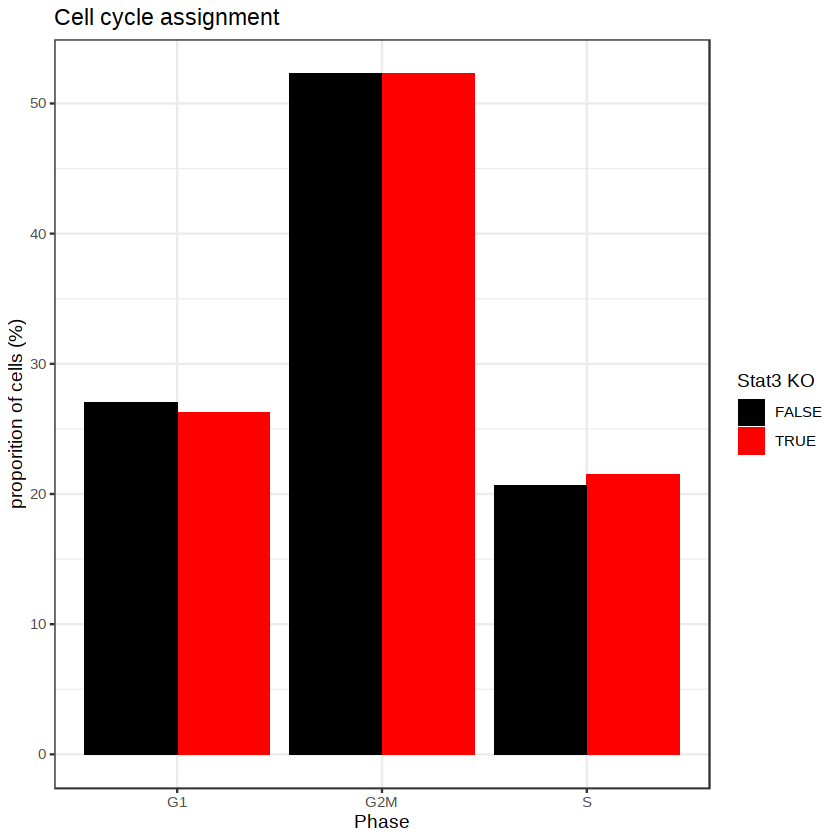

In [51]:
ggplot(props, aes(Phase, prop*100, fill=tdTom_corr)) + 
    geom_bar(stat='identity', position='dodge') + 
    scale_fill_manual(values=c('FALSE'='black','TRUE'='red'), name = 'Stat3 KO') +
    ggtitle('Cell cycle assignment') + 
    ylab('proporition of cells (%)') + 
    theme_bw()

In [52]:
# Split by celltype
meta = as.data.table(seurat@meta.data)
props = meta %>% 
    .[,Ntot:=.N, by=c('tdTom_corr', 'celltype.mapped_mnn')] %>%
    .[,prop:=.N/Ntot, by=c('Phase', 'tdTom_corr', 'celltype.mapped_mnn')] %>%
    unique(by=c('Phase', 'tdTom_corr', 'celltype.mapped_mnn'))

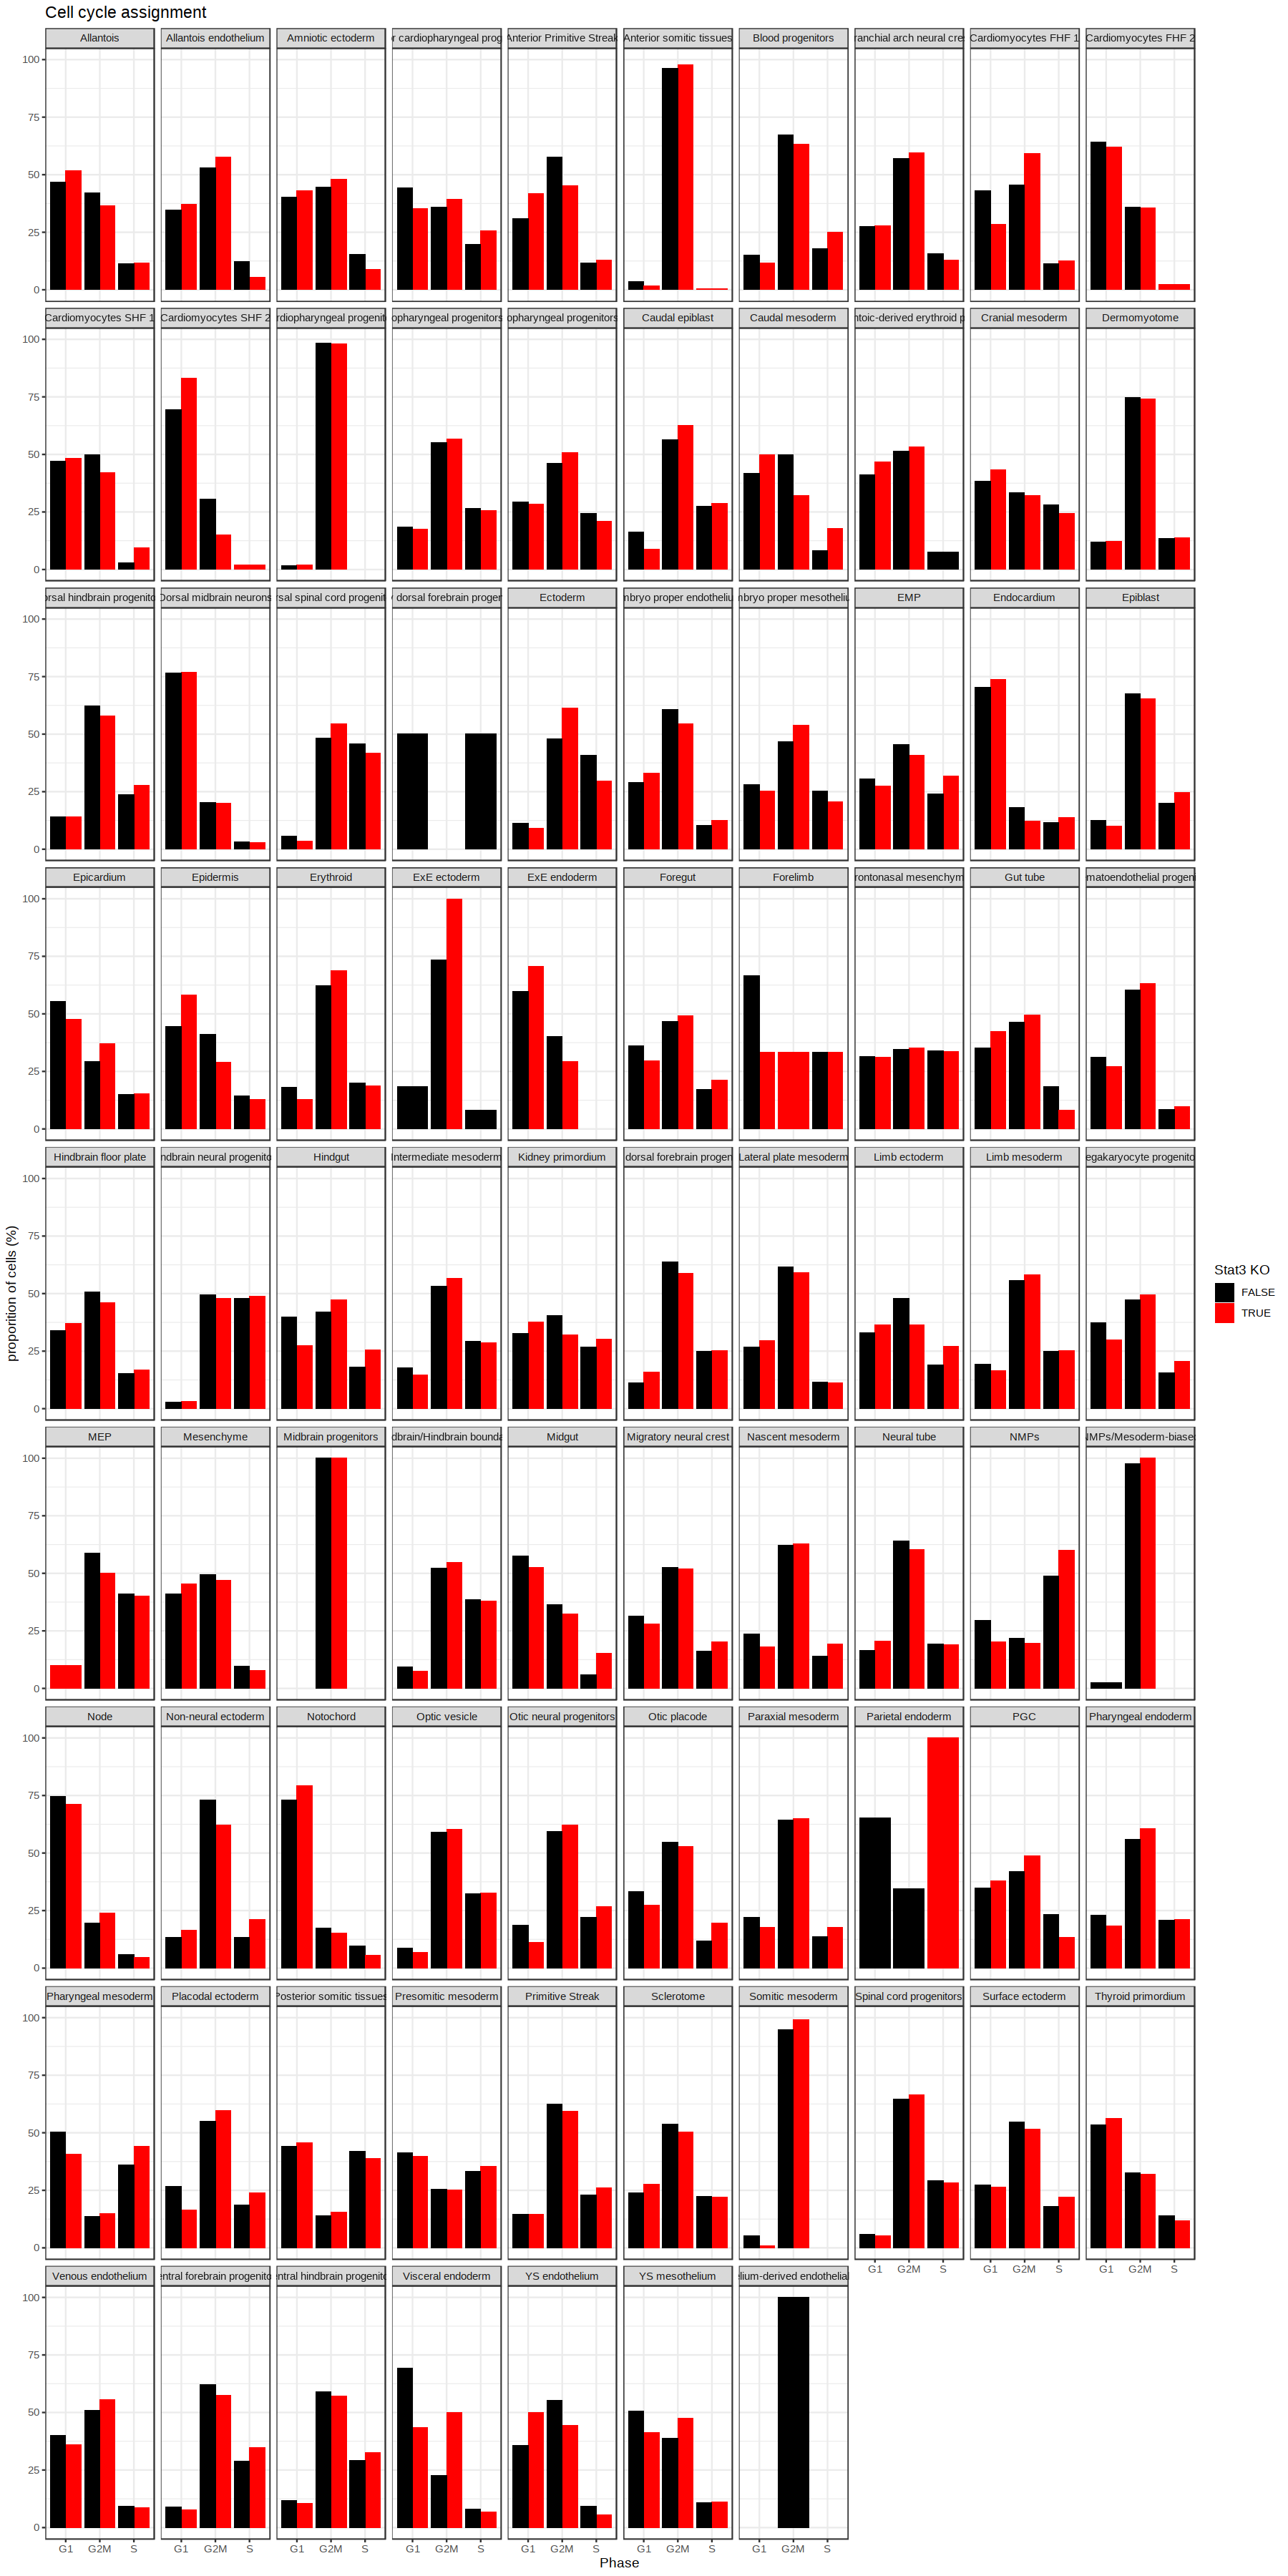

In [55]:
options(repr.plot.width=15, repr.plot.height=30) 

ggplot(props, aes(Phase, prop*100, fill=tdTom_corr)) + 
    geom_bar(stat='identity', position='dodge') + 
    scale_fill_manual(values=c('FALSE'='black','TRUE'='red'), name = 'Stat3 KO') +
    ggtitle('Cell cycle assignment') + 
    facet_wrap(~celltype.mapped_mnn) + 
    ylab('proporition of cells (%)') + 
    theme_bw()

In [56]:
# Split by stage
meta = as.data.table(seurat@meta.data)
props = meta %>% 
    .[,Ntot:=.N, by=c('tdTom_corr', 'stage')] %>%
    .[,prop:=.N/Ntot, by=c('Phase', 'tdTom_corr', 'stage')] %>%
    unique(by=c('Phase', 'tdTom_corr', 'stage'))

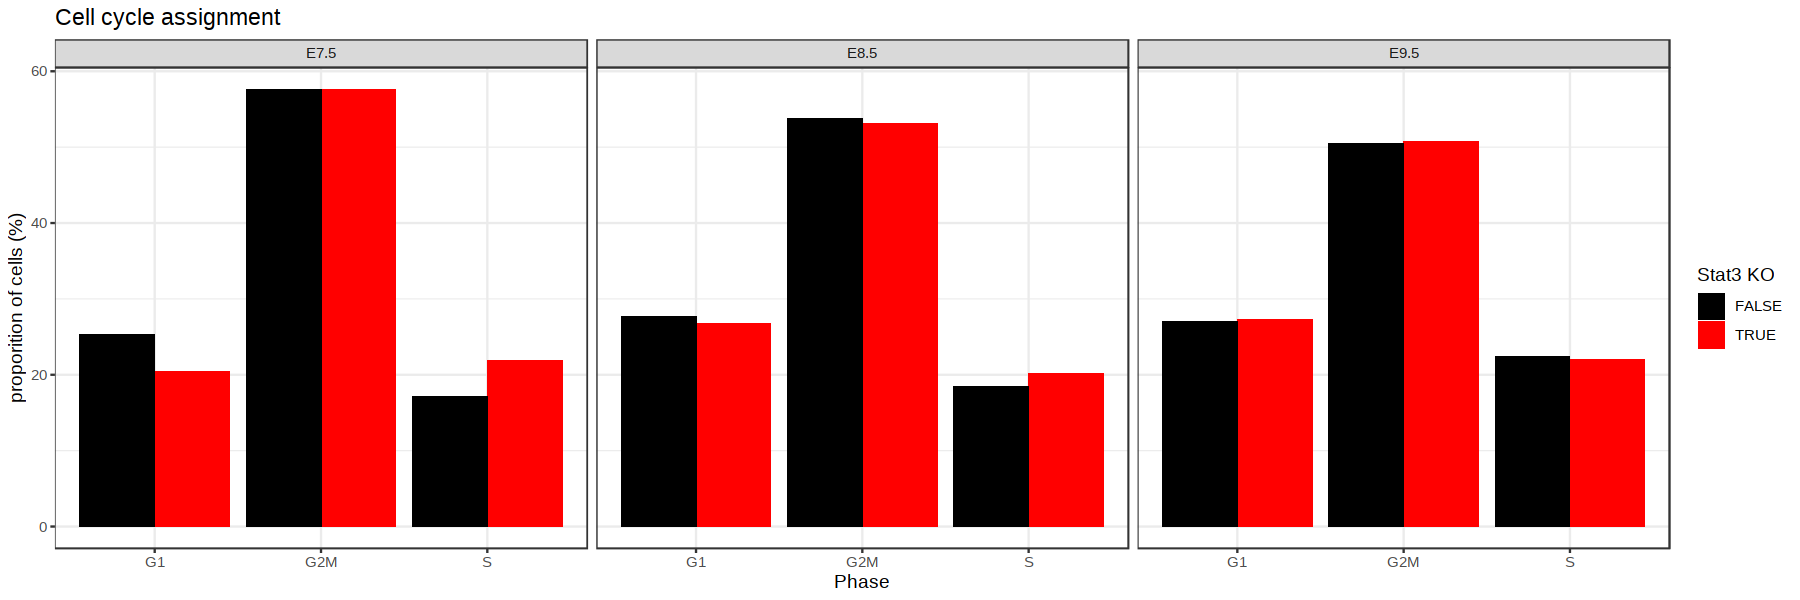

In [58]:
options(repr.plot.width=15, repr.plot.height=5) 

ggplot(props, aes(Phase, prop*100, fill=tdTom_corr)) + 
    geom_bar(stat='identity', position='dodge') + 
    scale_fill_manual(values=c('FALSE'='black','TRUE'='red'), name = 'Stat3 KO') +
    ggtitle('Cell cycle assignment') + 
    facet_wrap(~stage) + 
    ylab('proporition of cells (%)') + 
    theme_bw()